# Source Estimation with the Virtual Point Transformation
This notebook demonstrates how ForceFinder can be used for source estimation problems with the virtual point transformation, where the source estimation problem is posed as a simulated MIMO vibration test. This example uses the beam system that was developed [here](sec:example_beam_system) with a random vibration specification that is developed from a single DOF vibration specification in MIL-STD 810H. An image of the beam system is shown below, the blue arrows (the straight arrows above the beam) are the training response DOFs and the red arrows (below the beam) are the physical source DOFs. 

```{note}
The nodes are labeled 101-109 from left to right. The translating direction on the beam (vertical on the page) is Z+ and the rotating direction is RY+.
```

```{figure} images/beam_system_four_control_dofs.svg
:alt: Example Beam System
:align: center
```

The example data for this beam system is generated using the following process:

1. The SDynPy `System` object for the beam is imported
2. FRFs are computed for the beam system using the `frequency_response` method for the beams `System` object
3. A CPSD specification is made from a single DOF vibration test specification from MIL-STD 810H
4. The response and reference transformations will be manually created from the rigid body modes of the beam

In [1]:
import sdynpy as sdpy
import forcefinder as ff
import numpy as np
import matplotlib.pyplot as plt

In [2]:
beam_system = sdpy.System.load(r'./example_system/example_system.npz')

## Computing the FRFs
The FRFs are computed using a bandwidth of 5-500 Hz (which matches the specification that is defined below) and a frequency resolution 1 Hz. The displacement derivative is set to two, meaning the the FRFs are in accelerance format. The ordinate of the FRFs is divided by 9.81 to convert the FRFs from SI units to SI-G units (acceleration in Gs) to match the specification unit system.

In [3]:
frf_frequency = np.arange(496)+5
drive_coordinate = sdpy.coordinate_array(node=[102,104,106,108], direction=3)

frfs = beam_system.frequency_response(frf_frequency,
                                      references=drive_coordinate, 
                                      displacement_derivative=2)
frfs.ordinate /= 9.81

## Specification
The specification for this example is based off the unknonwn orientation "common carrier (US highway truck vibration exposure)" single DOF vibration test specification that is defined in MIL-STD 810H, method 514.8, annex C. This example problem is treating the beam as a shaker table, where the goal is to vibrate the beam as a rigid body. This is specified by applying same single axis specification PSD to each control DOF and using kinematic transformations to enforce the rigid behavior. The cross-terms for the specification CPSD is defined by a coherence 0.9 between each DOF and zero phase between each DOF. 

```{note}
The approach of applying a single axis vibration specification equally to all the control DOFs is for demonstration purposes only and should not be treated as an endorsement of the method. 
```

The specification from MIL-STD 810H is provided as a set of PSD breakpoints, which must be converted to a narrow band PSD before it can be turned into a MIMO specification. This conversion is done using log-log interpolation.

In [4]:
breakpoint_frequencies = [5,     40,    120,      121,   200,   240,    266,      500]
breakpoint_amplitudes =  [0.015, 0.015, 0.002025, 0.003, 0.003, 0.0015, 0.000475, 0.00015]

narrowband_specification = 10**(np.interp(np.log10(frf_frequency), 
                                          np.log10(breakpoint_frequencies), 
                                          np.log10(breakpoint_amplitudes)))

The coherence and phase for the specification are manually defined, as described above. Note that several extra steps are used in this code block to shape the arrays for the necessary operations. 

In [5]:
specification_psd = narrowband_specification[...,np.newaxis]*np.array(([[1,1,1,1]]*frf_frequency.shape[0]))

specification_phase = np.zeros((frf_frequency.shape[0],4,4), dtype=float)

specification_coherence = np.ones((4,4), dtype=float)*0.9
np.fill_diagonal(specification_coherence, 1)
specification_coherence = np.broadcast_to(specification_coherence[np.newaxis,...], 
                                          (frf_frequency.shape[0],4,4))

The PSDs, coherence, and phase are used to generate the full specification CPSD matrix for the simulated MIMO test using the `cpsd_from_coh_phs` function in SDynPy. The specification CPSD is initially generated as an `ndarray` in `specification_cpsd`. This `ndarray` is then populated into a SDynPy `PowerSpectralDensityArray` in `specification`.

In [6]:
specification_dofs = sdpy.coordinate_array(node=[102,104,106,108], direction=3)

specification_cpsd = sdpy.signal_processing.cpsd.cpsd_from_coh_phs(specification_psd, 
                                                                   specification_coherence, 
                                                                   specification_phase)

specification = sdpy.power_spectral_density_array(frf_frequency, 
                                                  np.moveaxis(specification_cpsd,0,-1),
                    sdpy.coordinate.outer_product(specification_dofs, specification_dofs))

## Creating the Transformation Arrays
This section creates the reference and response transformations that will be used in the source estimation, where the physical sources and specification will be transformed into a two DOF virtual point with Z+ and RY+ directions. This virtual point is shown as the red highlighted node with the arrows (representing the translating and rotation DOFs) in the image below.

```{figure} images/beam_system_virtual_point.svg
:alt: Example Beam System with Virtual Point
:align: center
```

The transformations are developed from the rigid body modes of the beam system using the geometry from the beam. The rigid body shapes are created `rigid_body_shapes` method for the SDynPy `Geometry` object and are set-up to have a center of gravity at the virtual point node. These shapes are then indexed to extract the Z+ and RY+ mode shape (since the `rigid_body_shapes` method returns shapes for all six directions).

In [7]:
beam_fem = sdpy.Geometry.load(r'./example_system/example_geometry.npz')

# Indexing the shapes from the method to extract only the Z+ and RY+ mode shapes
rigid_body_shapes = beam_fem.rigid_body_shapes(drive_coordinate, cg=[2,0,0])[[2,4]]

Animations of the shapes that are used to define the transformations are shown below.

```{figure} images/rigid_body_transformation_shape_1.gif
:alt: Translating Shape for Animation
:align: center
```

```{figure} images/rigid_body_transformation_shape_2.gif
:alt: Rotating Shape for Animation
:align: center
```

The reference transformation (for the sources) directly uses the rigid body shape matrix, which must be put into a SDynPy `Matrix` object to be compatible with the ForceFinder methods. This `Matrix` object is created with the rigid body shape matrix as the numeric data and SDynPy `CoordinateArrays` to label the row and column DOFs, which correspond to the virtual point and physical DOFs respectively. The virtual point DOFs will use 1001 as the node number.

In [8]:
virtual_point_dofs = sdpy.coordinate_array(node=1001, direction=[3,5])

reference_transformation = sdpy.matrix(matrix=rigid_body_shapes.shape_matrix, 
                                       row_coordinate=virtual_point_dofs, 
                                       column_coordinate=drive_coordinate)

The response transformation is a modal filter on the responses, which is created by inverting of the transpose of the rigid body shape matrix (since the SDynPy shape matrix puts the different shapes on different rows instead of columns). The modal filter is then put into a SDynPy `Matrix` object for compatibility with the ForceFinder methods. 

```{note}
The row and column `CoordinateArrays` are the same for the reference and response transformations in this example because the excitation and control DOFs are on the same nodes. This DOF layout is not always the case and is not a requirement in ForceFinder.
```

In [9]:
rigid_body_modal_filter = np.linalg.pinv(rigid_body_shapes.shape_matrix.T)

response_transformation = sdpy.matrix(matrix=rigid_body_modal_filter, 
                                      row_coordinate=virtual_point_dofs, 
                                      column_coordinate=drive_coordinate)

```{tip}
This example showed how to make the transformations manually. However, it may be useful to use the `force_kinematic_transformation` and `response_kinematic_transformation` methods in SDynPy to automatically create the transformation `Matrix` objects from a SDynPy `Geometry` object.
```

## Computing Sources with and without Transformations
This section creates the basic SPR object and estimates the drives with the basic pseudo-inverse method with and without the transformations. The the same SPR object can be used to estimate the sources with and without the transformations by toggling the `use_transformation` kwarg to either `True` or `False` (the default is `True`). This is shown below by making a copy of the SPR object with the `copy` method and estimating the sources with and without the transformations.

In [10]:
transformation_spr = ff.PowerSourcePathReceiver(frfs=frfs, 
                                        target_response=specification,
                                        response_transformation=response_transformation,
                                        reference_transformation=reference_transformation)
transformation_spr.manual_inverse(use_transformation=True)

'PowerSourcePathReceiver object with 4 reference coordinates, 4 target response coordinates, and 4 training response coordinates'

In [11]:
no_transformation_spr = transformation_spr.copy()
no_transformation_spr.manual_inverse(use_transformation=False)

'PowerSourcePathReceiver object with 4 reference coordinates, 4 target response coordinates, and 4 training response coordinates'

As expected, the sources that were estimated with the transformations have lower amplitudes than the sources that were estimated without the transformations. This plot compares the physical sources, but the transformed sources could have easily been compared by using the corresponding "transformed" attributes. Refer to the [attribute definitions](object_attribute_definitions) for a full list of the SPR object attributes.

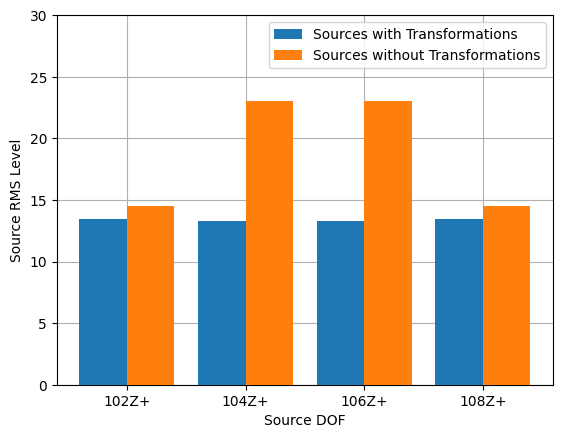

In [12]:
plt.figure()
plt.bar(np.arange(4)+0.3, transformation_spr.force.rms(), width=0.4, 
        label='Sources with Transformations', zorder=3)
plt.bar(np.arange(4)+0.7, no_transformation_spr.force.rms(), width=0.4, 
        label='Sources without Transformations', zorder=3)
plt.xticks(np.arange(4)+0.5, transformation_spr.reference_coordinate);
plt.xlabel('Source DOF')
plt.ylabel('Source RMS Level')
plt.ylim(top=30)
plt.legend()
plt.grid(zorder=0)

Interestingly, both sets of estimated sources (with and without the transformations) reconstruct the same transformed training response. This similarity is shown through a passing NumPy `allclose` comparison of the `transformed_reconstructed_response` attribute of the different SPR objects.

In [13]:
np.allclose(transformation_spr.transformed_reconstructed_response.ordinate, 
            no_transformation_spr.transformed_reconstructed_response.ordinate)

True

However, this similarity is not true for the reconstructed target responses, which are the training responses without the response transformation applied. This difference is shown through a failing NumPy `allclose` comparison of the `reconstructed_target_response`. 

In [14]:
np.allclose(transformation_spr.reconstructed_target_response.ordinate, 
            no_transformation_spr.reconstructed_target_response.ordinate)

False

It is also important to check that the estimated sources (with the transformations) reconstruct the expected response at both the virtual point and physical DOFs. This can be easily checked through one of the error metrics in ForceFinder. In this case, the [global ASD error](sec:global_asd_error) metric was used to evaluate the control accuracy. It is easy to compute this error metric for both the virtual point and physical DOFs by changing the `channel_set` kwarg for the error metric to `training` (which computes the error for the virtual point) and `target` (which computes the error for the physical DOFs). 

This metric shows that there are significant errors in the responses at the physical DOFs even though the virtual point DOFs show zero error. The reason for this difference in error is because the transformation assumes that the beam behaves as a rigid system, which is obviously not the case. As such, the source estimation with the transformation is not able to move the excitation and response DOFs independently to eliminate the elastic behavior and achieve the goal of the specification.

```{warning}
Transformations can lead non-intuitive results if the source estimation problem is not closely inspected or if the transformations are used in an inappropriate fashion. This example was developed to show these non-intuitive results, which is why there are such significant errors. 
```

In [15]:
transformed_global_asd_error = transformation_spr.global_asd_error(channel_set='training')
physical_global_asd_error = transformation_spr.global_asd_error(channel_set='target')

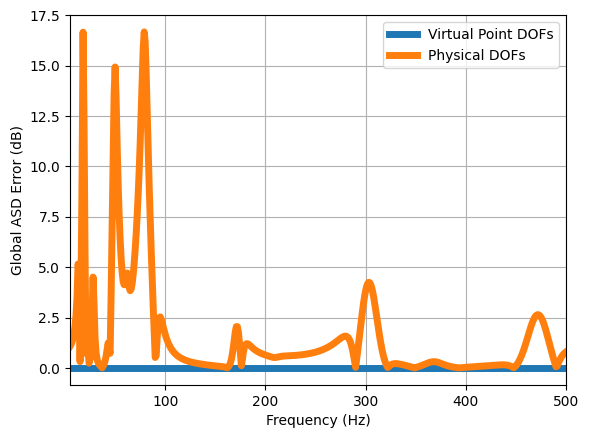

In [16]:
plt.figure()
plt.plot(transformed_global_asd_error.abscissa, np.abs(transformed_global_asd_error.ordinate), 
         label='Virtual Point DOFs', linewidth=5)
plt.plot(physical_global_asd_error.abscissa, np.abs(physical_global_asd_error.ordinate),
         label='Physical DOFs', linewidth=5)
plt.xlim(left=5, right=500)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Global ASD Error (dB)')
plt.legend()
plt.grid()